In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import utils

In [2]:
%load_ext autoreload
%autoreload 3

In [3]:
logdir = 'runs/resnet'
# track runing logs
writer = SummaryWriter(logdir)

In [3]:
root = '../data'
# Download training data from open datasets.
training_data = datasets.EMNIST(
    root=root,
    split="byclass",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.EMNIST(
    root=root,
    split="byclass",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True,num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size,num_workers=0)


In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda


In [6]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=12544,out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=62)
        

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x += identity
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        output = self.fc2(x)
        return output

In [8]:
model = NeuralNetwork().to(device)

In [9]:
lr = 1e-4
# 损失函数
loss_fn = nn.CrossEntropyLoss()
# 梯度下降算法 优化器
# optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [10]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    utils.train(train_dataloader,device, model, loss_fn, optimizer)
    utils.test(test_dataloader,device, model, loss_fn)
    utils.write_loss_acc(writer,device,t,model,loss_fn,train=train_dataloader,test=test_dataloader)
print("Done!")

Epoch 1
-------------------------------
loss: 4.173567  [    0/697932]
loss: 1.249734  [64000/697932]
loss: 0.851622  [128000/697932]
loss: 1.115899  [192000/697932]
loss: 1.511886  [256000/697932]
loss: 0.627277  [320000/697932]
loss: 0.766652  [384000/697932]
loss: 0.794250  [448000/697932]
loss: 0.539617  [512000/697932]
loss: 0.748940  [576000/697932]
loss: 0.676575  [640000/697932]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.497415 

Epoch 2
-------------------------------
loss: 0.465767  [    0/697932]
loss: 0.565385  [64000/697932]
loss: 0.632834  [128000/697932]
loss: 0.723434  [192000/697932]
loss: 0.737585  [256000/697932]
loss: 0.770942  [320000/697932]
loss: 0.696516  [384000/697932]
loss: 0.435946  [448000/697932]
loss: 0.514329  [512000/697932]
loss: 0.448769  [576000/697932]
loss: 0.404444  [640000/697932]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.435923 

Epoch 3
-------------------------------
loss: 0.784974  [    0/697932]
loss: 0.716911  [64000/697932]
loss: 0.638433

In [7]:
# model = torch.load('resnet_model',map_location=device)

In [ ]:
# check f1 score 
utils.compute_f1(test_dataloader,device,model)

In [8]:
# all classes in order
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
           'U', 'V', 'W', 'X', 'Y', 'Z','a', 'b', 'c', 'd', 
           'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
           'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z')

f1 score in micro : 0.8653834581295187
f1 score in weighted : 0.8480242021507143


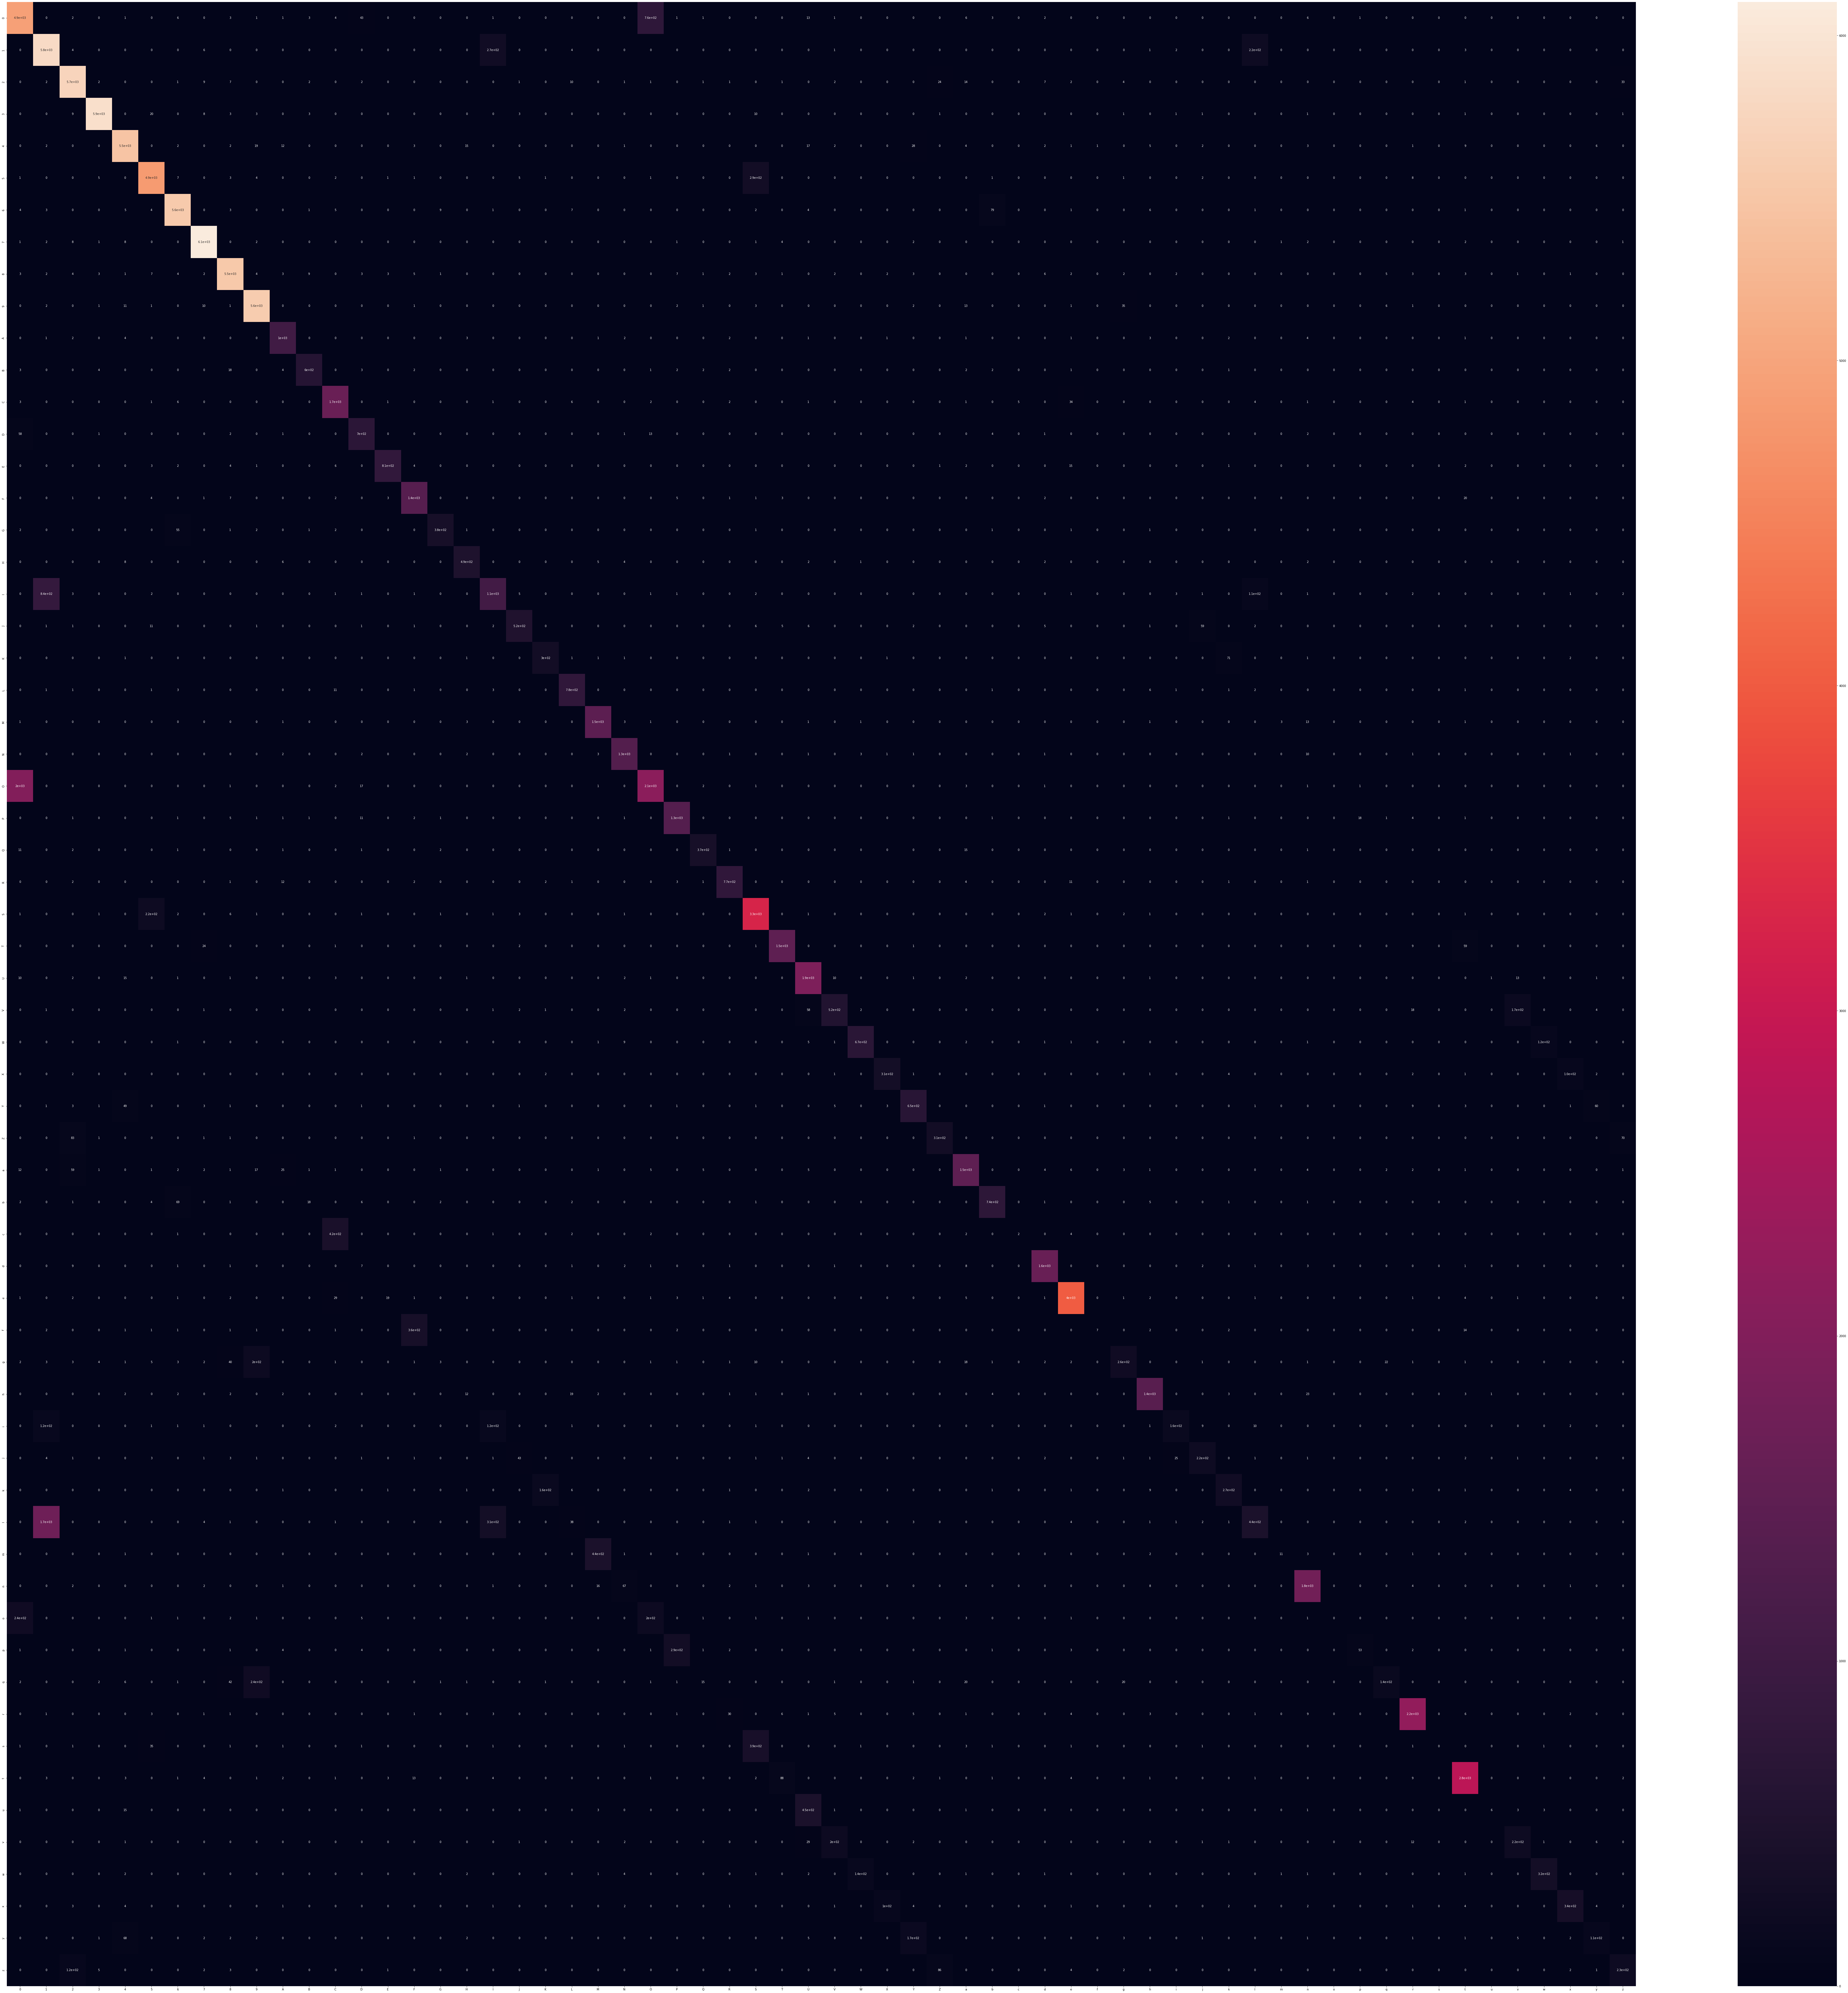

In [9]:
# check confusion matrix
utils.get_CM(test_dataloader,device,model,classes,savefile='resnet_CM.png')

In [14]:
# torch.save(model,'resnet_model')